## MPC trajectory tracking with magnet dynamics

Team 1 \
24-774 Advanced Control System Integration, Carnegie Mellon University\
Fall 2024

In [1]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()

using Libdl
using LinearAlgebra
using BlockDiagonals
import ForwardDiff as FD
using Plots
using CSV
using DataFrames
using Interpolations   
import ECOS  
using ProgressMeter
import MeshCat as mc 
using Test, Distributions
using Random
using DelimitedFiles


  Activating project at `~/CMU/24-774 Advanced Control Systems Integration/project/traj_gen_v2`


In [ ]:
# load all files

############################
#data= CSV.read("f8_FD_4boards.csv", DataFrame; header=1)
#data= CSV.read("cloud_FD_4boards.csv", DataFrame; header=1)
#data= CSV.read("circle_FD_4boards.csv", DataFrame; header=1)
#data= CSV.read("human_head.csv", DataFrame; header=1)
#data= CSV.read("kitty_FD.csv", DataFrame; header=1)
data= CSV.read("text_FD.csv", DataFrame; header=1)
###########################

include(joinpath(@__DIR__, "CrazyflieDynamics_withMagnet.jl")) # drone dynamics, quaternion stuff
include(joinpath(@__DIR__, "convex_mpc.jl")) # convex mpc setup
include(joinpath(@__DIR__, "visualization.jl")) # mesh cat visualizer, plots


animate_Crazyflie_record (generic function with 1 method)

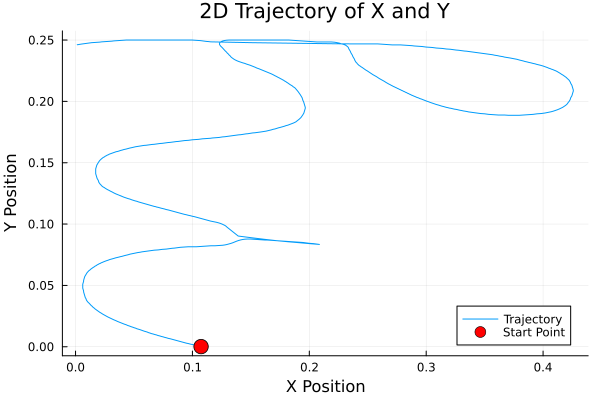

In [161]:
# input trajectory processing

# Access each column to build state vector
pos_x = data[1:end, :x] 
pos_y = data[1:end, :y]
pos_z = data[1:end, :z]
vel_x = data[1:end, :u]
vel_y = data[1:end, :v]
vel_z = data[1:end, :w]
angpos_phi = float(data[1:end, :phi])
angpos_theta = float(data[1:end, :theta])
angpos_psi = float(data[1:end, :psi])
angvel_p = data[1:end, :p]
angvel_q = data[1:end, :q]
angvel_r = data[1:end, :r]

# combine into state vector
Nsim= length(pos_x)
Xref = [zeros(12) for i = 1:Nsim]

for i in 1:Nsim
    # convert to quaternions
    quaternion= euler_to_quaternion(angpos_phi[i], angpos_theta[i], angpos_psi[i])
    Xref[i] = [pos_x[i], pos_y[i], pos_z[i], quaternion[1], quaternion[2], quaternion[3], quaternion[4], vel_x[i], vel_y[i], vel_z[i], angvel_p[i], angvel_q[i], angvel_r[i]]
end

# plot the xy trajectory for visualization
plot(pos_x, pos_y, label="Trajectory", xlabel="X Position", ylabel="Y Position", title="2D Trajectory of X and Y")
scatter!([pos_x[1]], [pos_y[1]], color=:red, label="Start Point", markersize=8)


In [162]:
# Crazyflie model parameters
model = (
    mass = 0.032499 + 0.001386,  # mass
    J = [(1.66e-5+1.089e-6) 0.83e-6 0.72e-6; 0.83e-6 (1.66e-5+1.041e-6) 1.8e-6; 0.72e-6 1.8e-6 (2.93e-5+0.134e-6)],  # inertia matrix updated with rigid body mass
    g = 9.81,  # gravity
    thrustToTorque = 0.0008,  # thrust to torque ratio
    ℓ = 0.046/1.414213562,  # arm length
    PWM = 65535,  # PWM scale
    kt = 2.245365e-6*65535, # thrust coefficient
    km = 2.245365e-6*65535*0.0008, # moment coefficient
    freq =  100.0, # control frequency
    dt = 0.01 # 100 Hz
)


(mass = 0.033885, J = [1.7689e-5 8.3e-7 7.2e-7; 8.3e-7 1.7641e-5 1.8e-6; 7.2e-7 1.8e-6 2.9434e-5], g = 9.81, thrustToTorque = 0.0008, ℓ = 0.03252691194316237, PWM = 65535, kt = 0.147149995275, km = 0.00011771999622000001, freq = 100.0, dt = 0.01)

In [ ]:
# Problem set up
nx1 = 13        # number of states (quaternion)
nx = 12         # number of states (linearized): x, y, z, Rodriguez 3-parameters (p, q, r), vx, vy, vz, wx, wy, wz
nu = 4          # number of controls

# Hovering state and control input
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
X̄ = [rg; qg; vg; ωg]

#magnet_force_z = 4.00338  # Magnet force in the z-direction (N)
magnet_force_z = 2.00 # to consider that it is not making full contact
Ū = ((model.mass * model.g + magnet_force_z) / model.kt / 4) * ones(4) # m = 30g and max thrust = 60g
 
@show X̄, Ū


([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [3.9626434333910314, 3.9626434333910314, 3.9626434333910314, 3.9626434333910314])

In [164]:
# LINEARIZATION
# linearized around a hover (with the controls being to counteract hover)
Anp = FD.jacobian(x->quad_dynamics_rk4(x,Ū, model.dt),X̄) # in the world frame
Bnp = FD.jacobian(u->quad_dynamics_rk4(X̄,u, model.dt),Ū);

#println((Bnp))
# println(size(Anp))

13×4 Matrix{Float64}:
 -7.4855e-6     8.18344e-6    7.50868e-6   -8.20662e-6
  7.43057e-6    8.13682e-6   -7.43888e-6   -8.12851e-6
  0.000217131   0.000217131   0.000217131   0.000217131
  0.0           0.0           0.0           0.0
 -0.00647702   -0.00709265    0.00648427    0.0070854
 -0.00652491    0.00713328    0.00654512   -0.00715349
  0.000457474  -0.000162744  -0.00065886    0.00036413
 -0.0029942     0.00327338    0.00300347   -0.00328265
  0.00297223    0.00325473   -0.00297555   -0.0032514
  0.0434263     0.0434263     0.0434263     0.0434263
 -2.59081      -2.83706       2.59371       2.83416
 -2.60996       2.85331       2.61805      -2.8614
  0.18299      -0.0650975    -0.263544      0.145652

In [ ]:
# stability check (using infinite horizon LQR)

### cost matrix definitions
max_dev_x = [0.01; 0.01; 0.01; 0.05; 0.5; 0.03; 0.03; 0.5; 0.5; 0.5; 0.7; 0.7; 0.7]
max_dev_u = [0.1; 0.1; 0.1; 0.1]/6
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))
Qn = 10*Q

# IHLQR- using the steady state P as Qn for the MPC controller
# Riccati recursion on the linearized dynamics
Kinf= Bnp'
max_iters= 1e6
P= deepcopy(Qn) #initialize p
for i= 1:max_iters
    Kinf = (R .+ Bnp' * P * Bnp)\  (Bnp' * P * Anp)
    P_recursion = Q + Anp' * P * Anp - Anp' * P * Bnp * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end 
    # update P for next iteration
    P = 1*P_recursion
end
# ensure that Qn is hermitian 
Qn= 1*(P +P')/2;

##### TESTS #####
# check the norm of the nonlinear disretized dynamics to make sure they match at the equilibrium point
println("norm between X̄ and discretized dynamics= ", norm(X̄- quad_dynamics_rk4(X̄, Ū, model.dt)))
@assert norm(X̄- quad_dynamics_rk4(X̄, Ū, model.dt)) < 1e-3

# check for system stability
eig= abs.(eigvals(Anp- Bnp*Kinf))
# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end
println("eigenvalues= ",eig)


In [174]:
# MPC setup
#horizonLength = 100  # horizon length
#horizonLength = 75  # horizon length #fig8 and circle, hi
#horizonLength = 50  # horizon length
horizonLength = 20  # horizon length # cloud and human, cat

# inequality constraints
x_min = -1000. * ones(nx1)  # state constraints
x_max = 1000. * ones(nx1)  # state constraints

u_min = (-1.686 * ones(nu)).- Ū  # force constraints
u_max = (5.6 * ones(nu)) .- Ū ; # force constraints

println("umin= ", u_min)
println("umax= ", u_max)

In [ ]:
# MPC solve using convex mpc

#trajectory generation- figure 8- with velocity
xref = [zeros(nx1) for i in 1:length(Xref)] #this is delta x 
for k = 1:length(Xref)
    x_ = Xref[k]   
    xref[k] .= [x_[1:3]-rg; x_[4:7]- qg; x_[8:10]-vg; x_[11:13]-ωg]
end

NSIM = length(xref)+ horizonLength
# pad Xref with terminal conditions so that we can make it to the end of the trajectory when following a window ahead of the trajectory
xref = [xref...,[xref[Nsim] for i = 1:NSIM]...]  # Xref for MPC, padded with xgoals

# simulation states
X_sim = [zeros(nx1) for i = 1:NSIM]
X_sim[1] = 1*Xref[1] # + randn(n_states) * 0.001
deltaX_sim = [zeros(nx1) for i = 1:NSIM]
deltaX_sim[1] = X_sim[1] - X̄ 
goal= 1* Xref[Nsim]

# simulation
u_current = [zeros(nu) for i in 1:NSIM-1]
@showprogress "simulating" for i in 1:(NSIM-1)

    # given a window of horizonLength timesteps, get current reference trajectory
    xref_horizon = xref[i: (i+horizonLength-1)] #ΔX_ref[i: (i+ N_mpc-1)] 

    # call convex mpc controller with state estimate 
    u_current[i] = convex_mpc(Anp, Bnp, xref_horizon, deltaX_sim[i], u_min, u_max, x_min, x_max, horizonLength, Q, R, Qn, Ū)  #+ randn(n_inputs) * 0.01
    # sim forward
    X_sim[i+1] = quad_dynamics_rk4(X_sim[i], u_current[i], model.dt)

    # update for next MPC call
    deltaX_sim[i+1]= X_sim[i+1] - X̄

end

In [ ]:
### feedforward term calculation
c = zeros(13)
c[10] = -model.g # Offset vector in system dynamics

# System parameters (define these based on your setup)
# A = ...   # State transition matrix
# B = ...   # Control input matrix
# Q = ...   # State cost matrix
# R = ...   # Control cost matrix
# Q_N = ... # Terminal state cost
q_N = zeros(13)  # Terminal linear cost vector
rk = zeros(4)  # Control cost linear term (if applicable)

# Horizon length
N = length(X_sim) #- 1  # Assuming x_trajectory includes all states

# Pre-allocate arrays for P, p, K, and d
P = Array{Matrix{Float64}}(undef, N+1)  # Quadratic term of cost-to-go
p = Array{Vector{Float64}}(undef, N+1)  # Linear term of cost-to-go
K = Array{Matrix{Float64}}(undef, N)    # Feedback gains
d = Array{Vector{Float64}}(undef, N)    # Feedforward terms

# Initialize terminal cost
P[N+1] = Qn
p[N+1] = q_N

# Backward recursion to compute P, p, K, and d
for k in N:-1:1
    # Riccati backward step
    S = R + Bnp' * P[k+1] * Bnp
    Gff = Bnp' * P[k+1] * Anp
    K[k] = S \ Gff               # Feedback gain
    d[k] = S \ (Bnp' * (p[k+1] + P[k+1] * c) + rk)
    P[k] = Q + K[k]' * R * K[k] + (Anp - Bnp * K[k])' * P[k+1] * (Anp - Bnp * K[k])
    p[k] = q_N + (Anp - Bnp * K[k])' * (p[k+1] - P[k+1] * Bnp * d[k] + P[k+1] * c) +
           K[k]' * (R * d[k] - rk)
end

# Calculate the feedforward term for each step in the trajectory
d_feedforward = [d[k] for k in 1:N]
K_feedback = [K[k] for k in 1:N]

# println(size(X_sim))
# println((d_feedforward))
# println(size(d))

# d_feedforward in terms of single thrust and angles

In [ ]:
# Specify the file path

# Convert vector-of-vectors to matrices
X_sim_flat = reduce(hcat, X_sim)  # Each column is an inner vector
d_flat = reduce(hcat, d_feedforward)          # Flatten to matrix
K_flat = reduce(hcat, K_feedback)          # Flatten to matrix

# Combine all data horizontally
data_to_write = hcat(X_sim_flat', d_flat')  

# Write to CSV
file_path = "output_fig8FD_4board_MAGNET.csv"
#file_path = "output_cloudFD_4board_MAGNET.csv"
#file_path = "output_circleFD_4board_MAGNET.csv"
#file_path = "output_humanFD_4board_MAGNET_morepoints.csv"
#file_path = "output_cat_2000points.csv"
#file_path = "output_hi_1000pointsMAGNET.csv"

writedlm(file_path, data_to_write, ',')

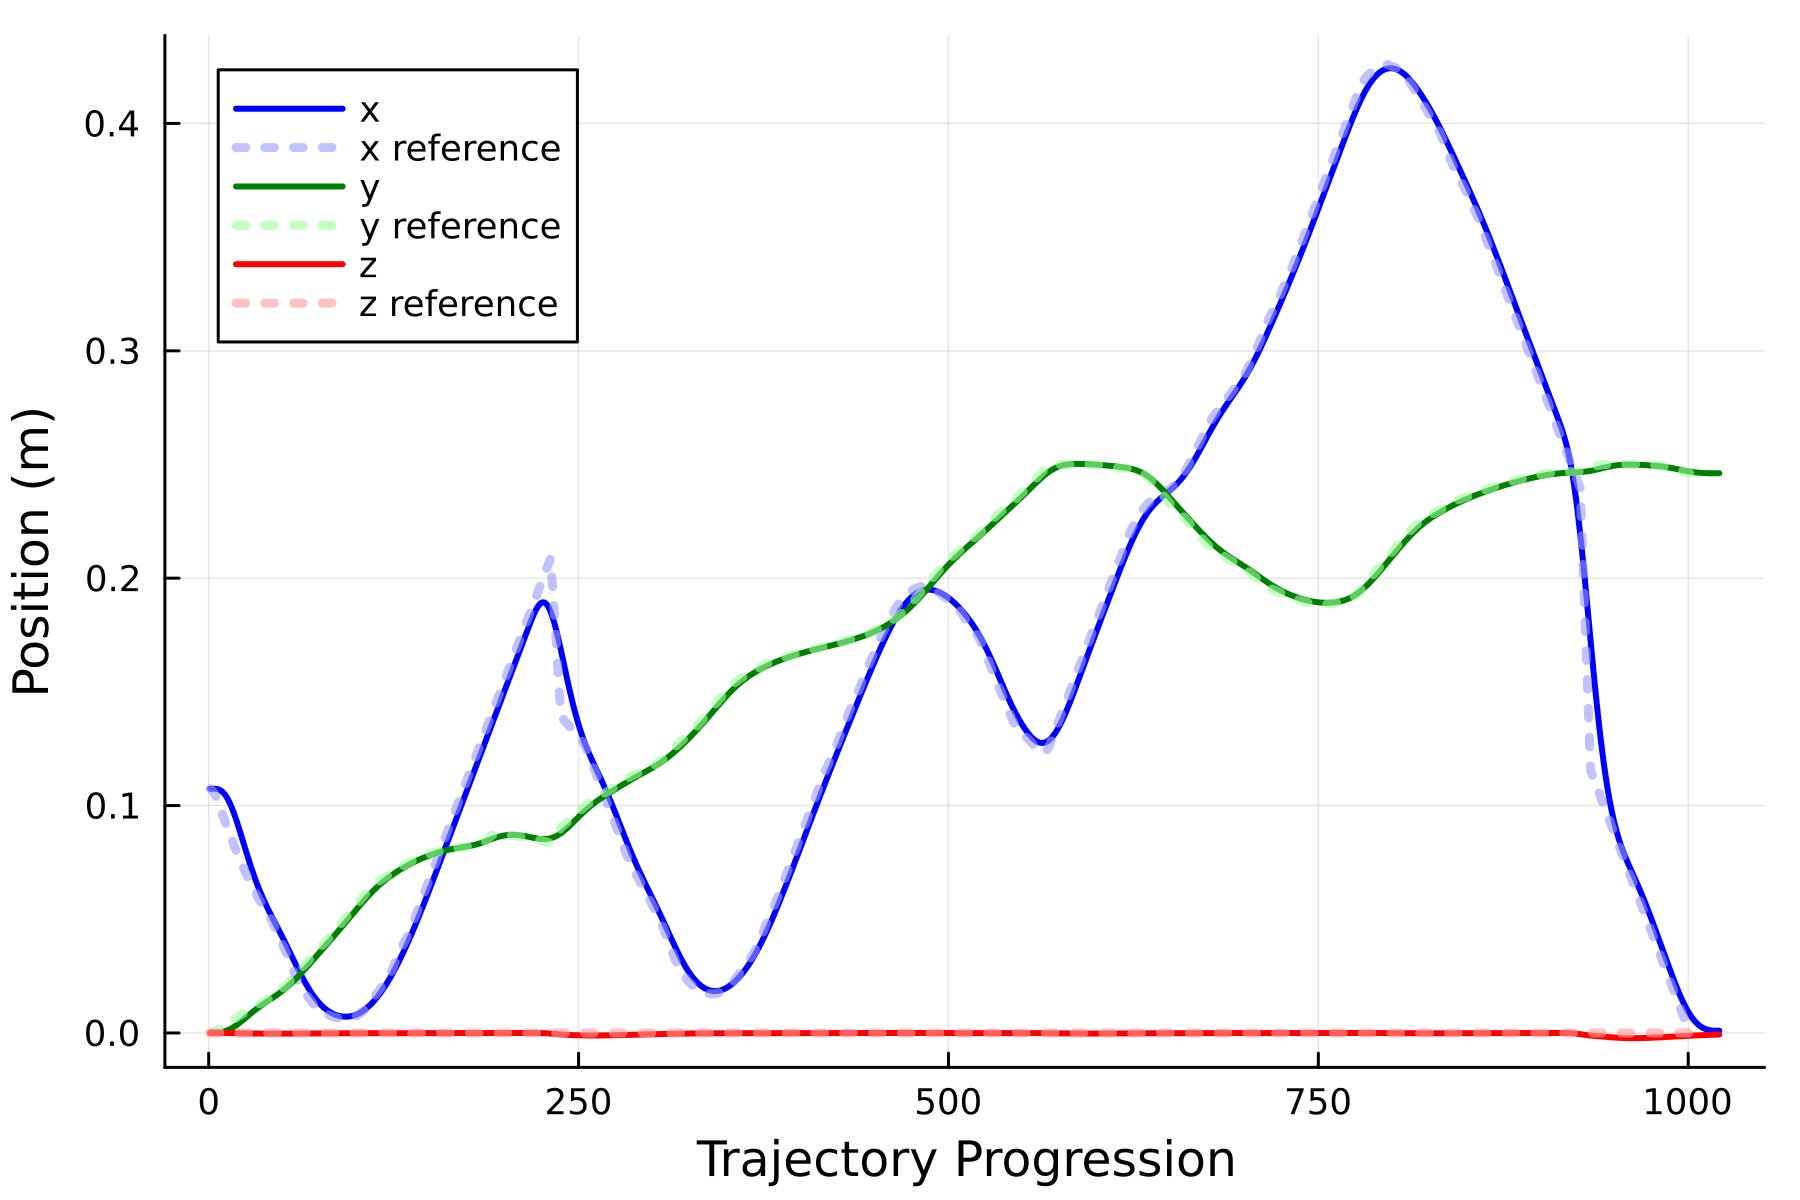

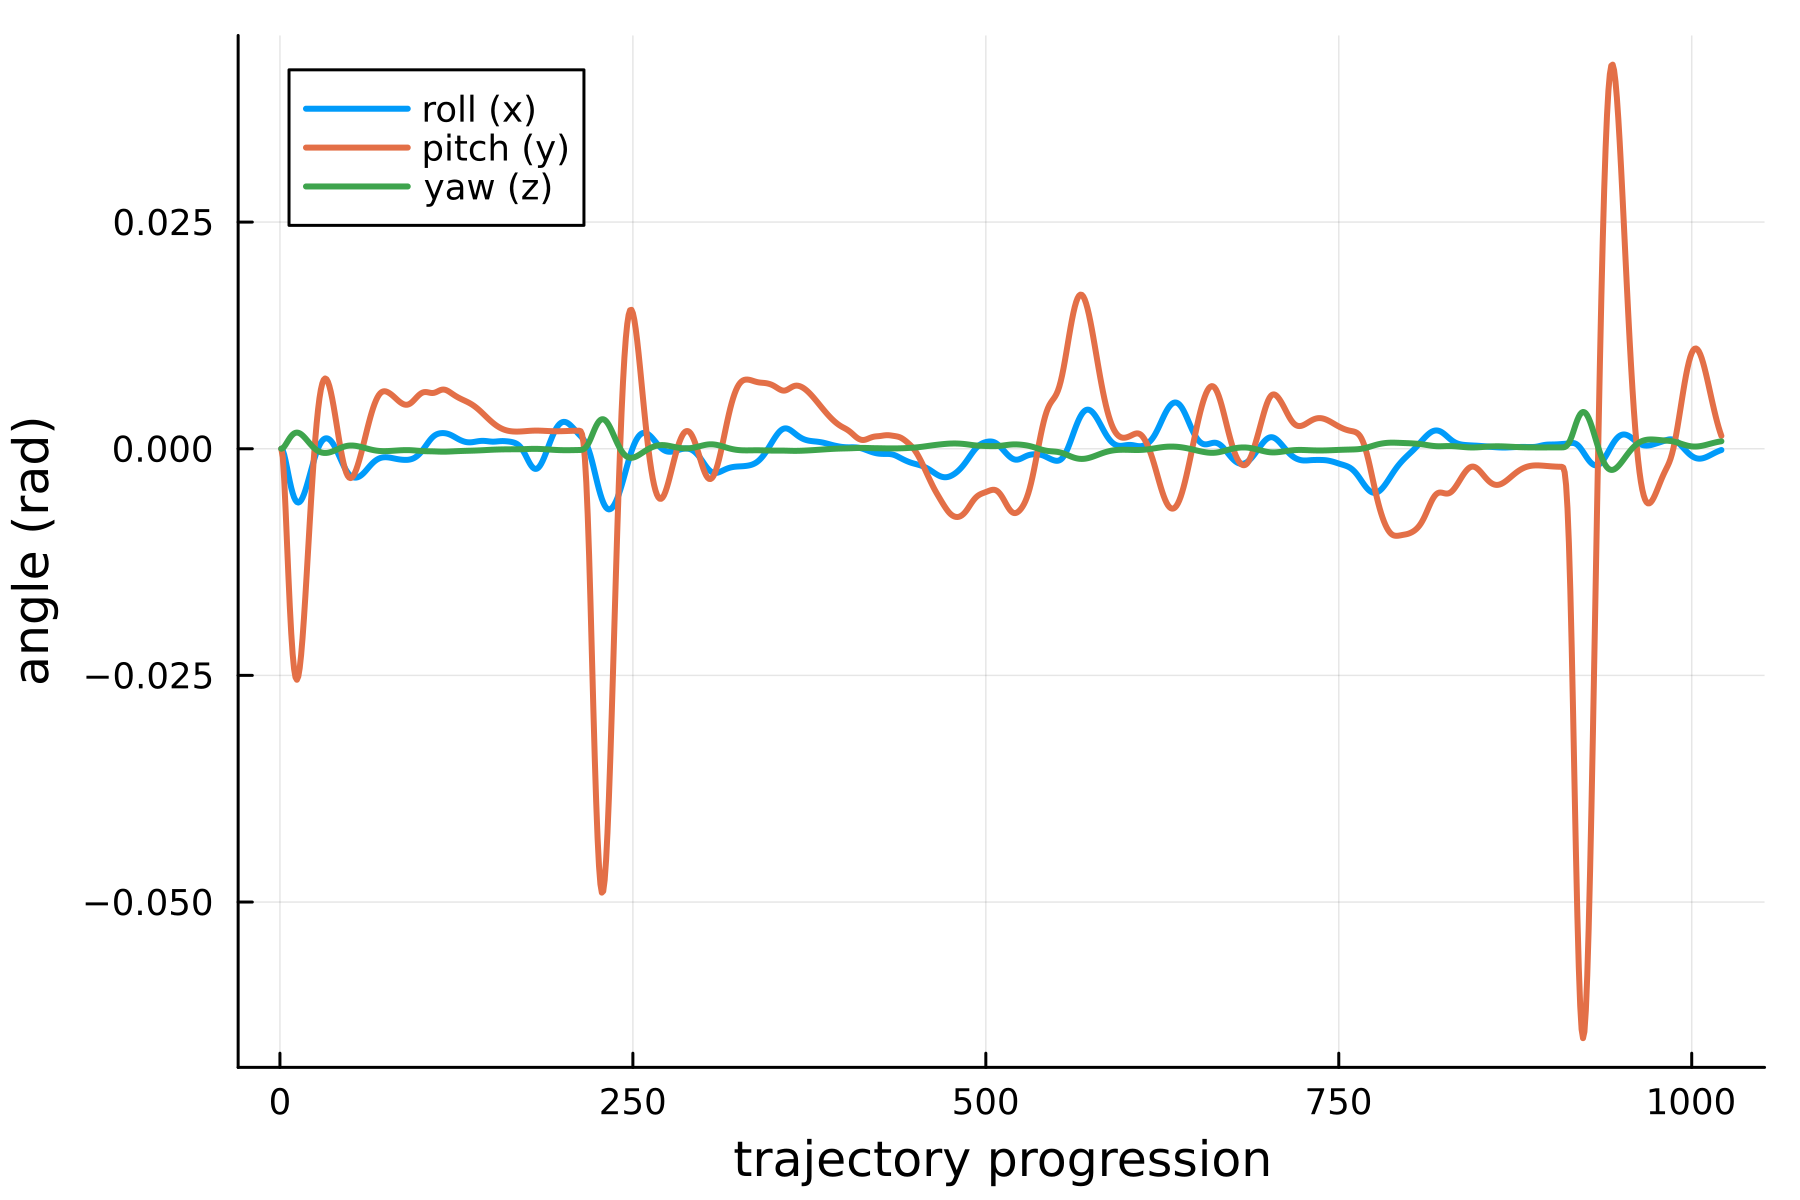

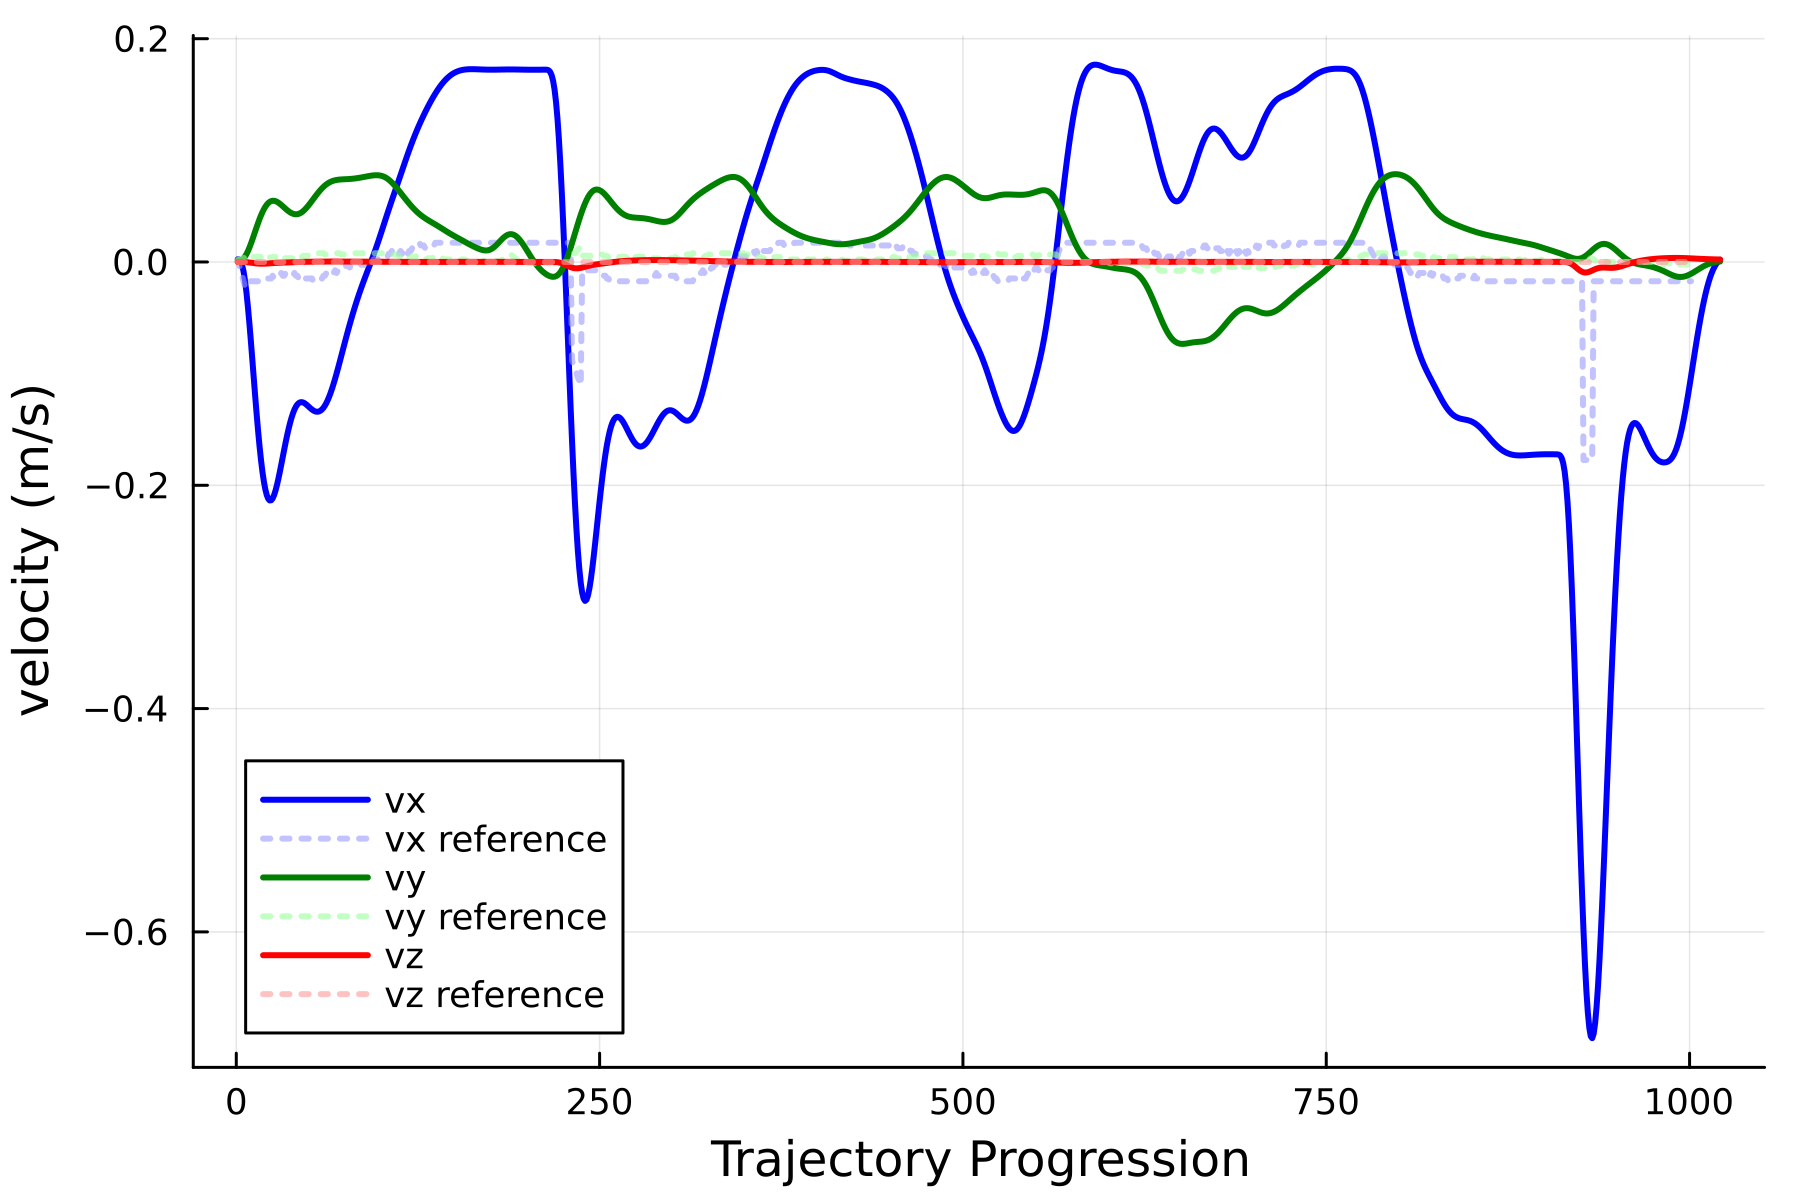

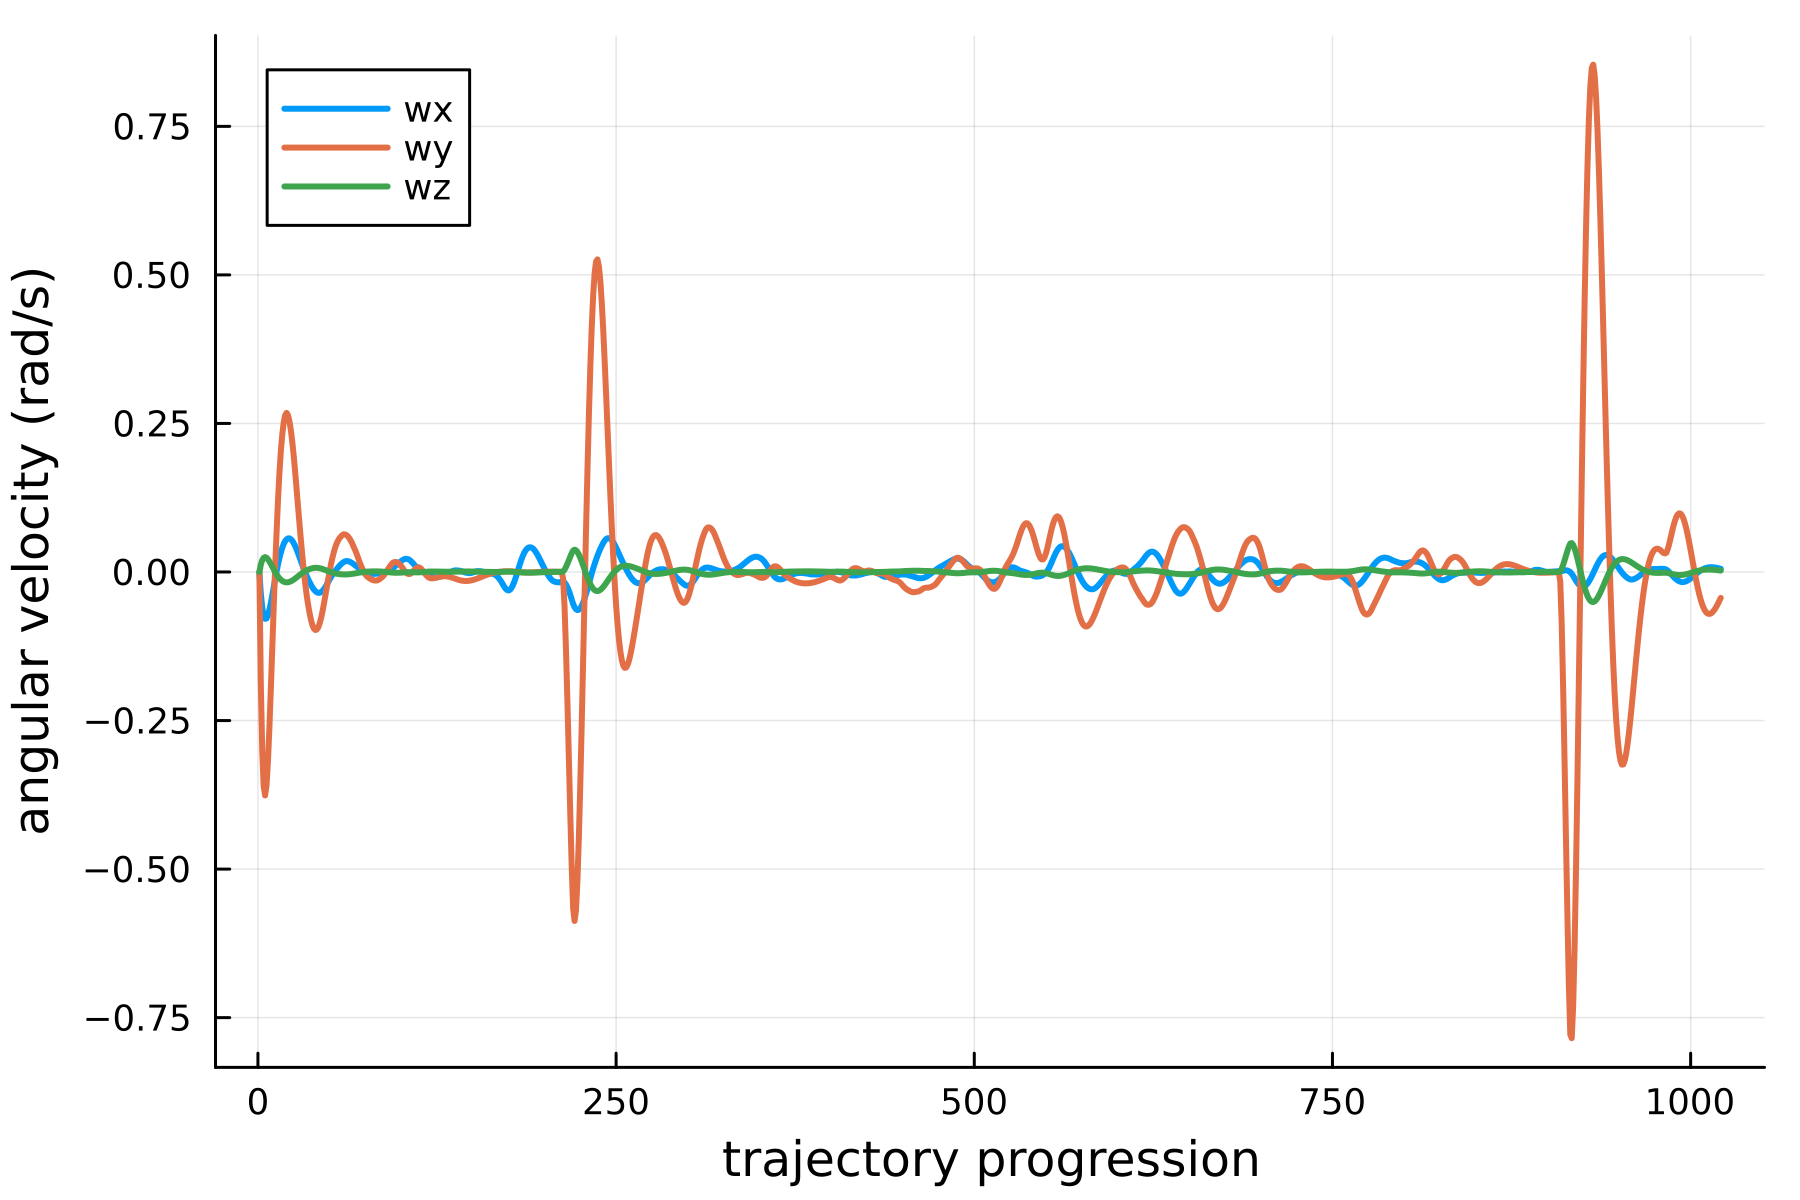

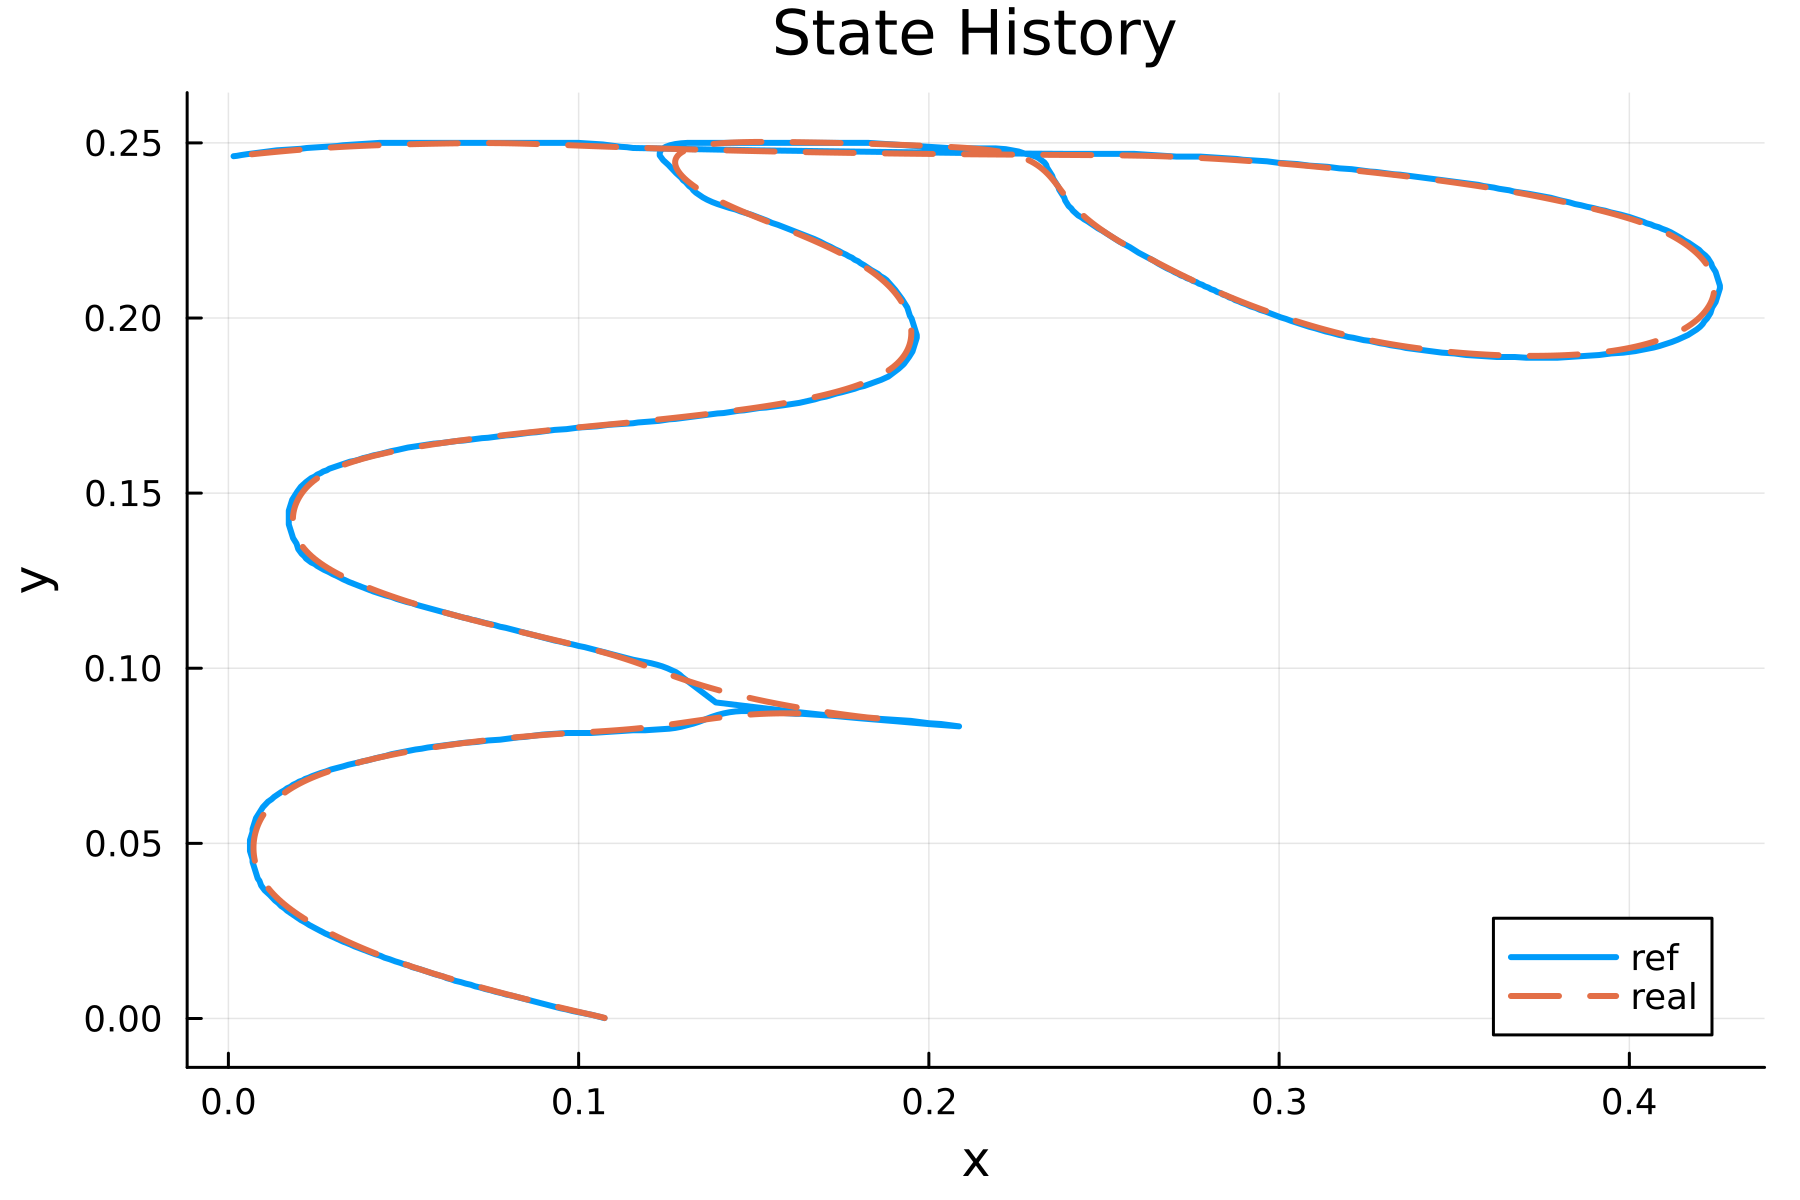

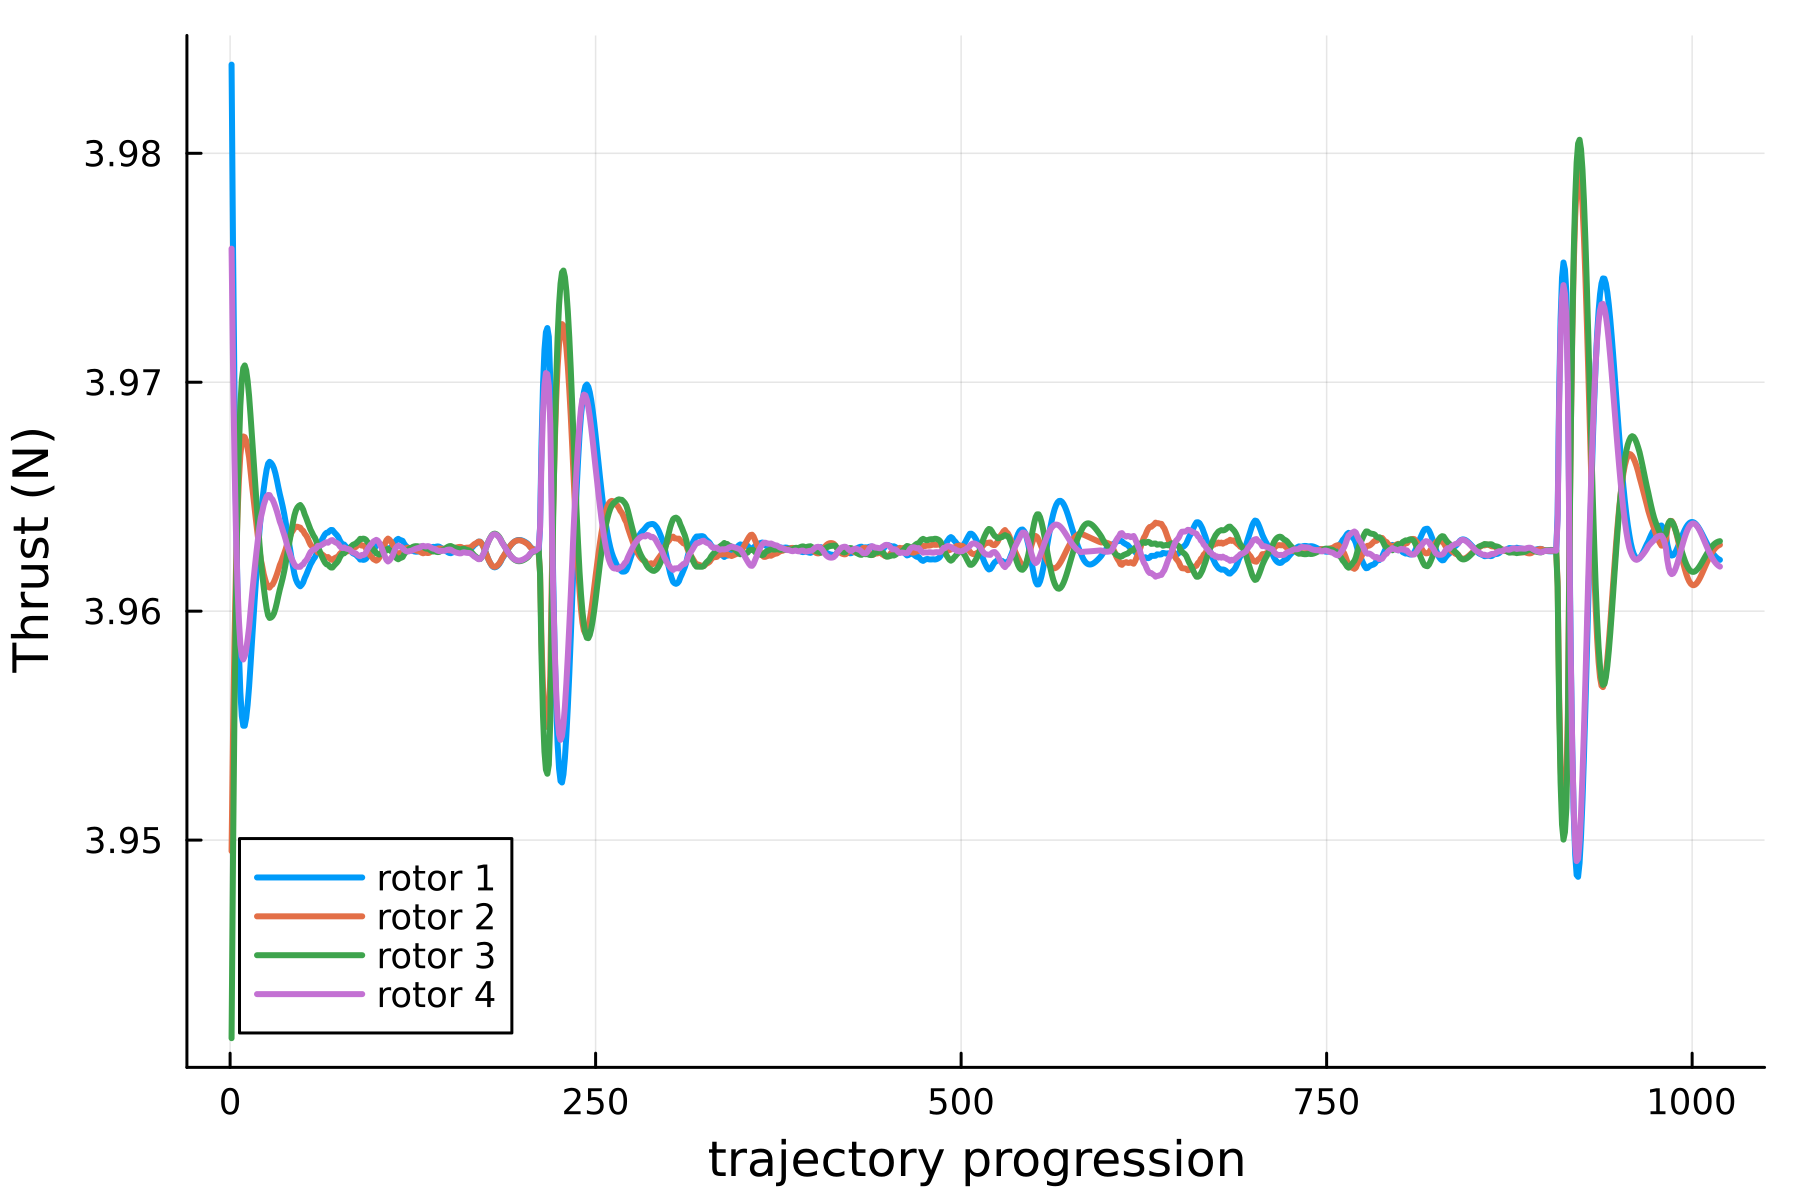

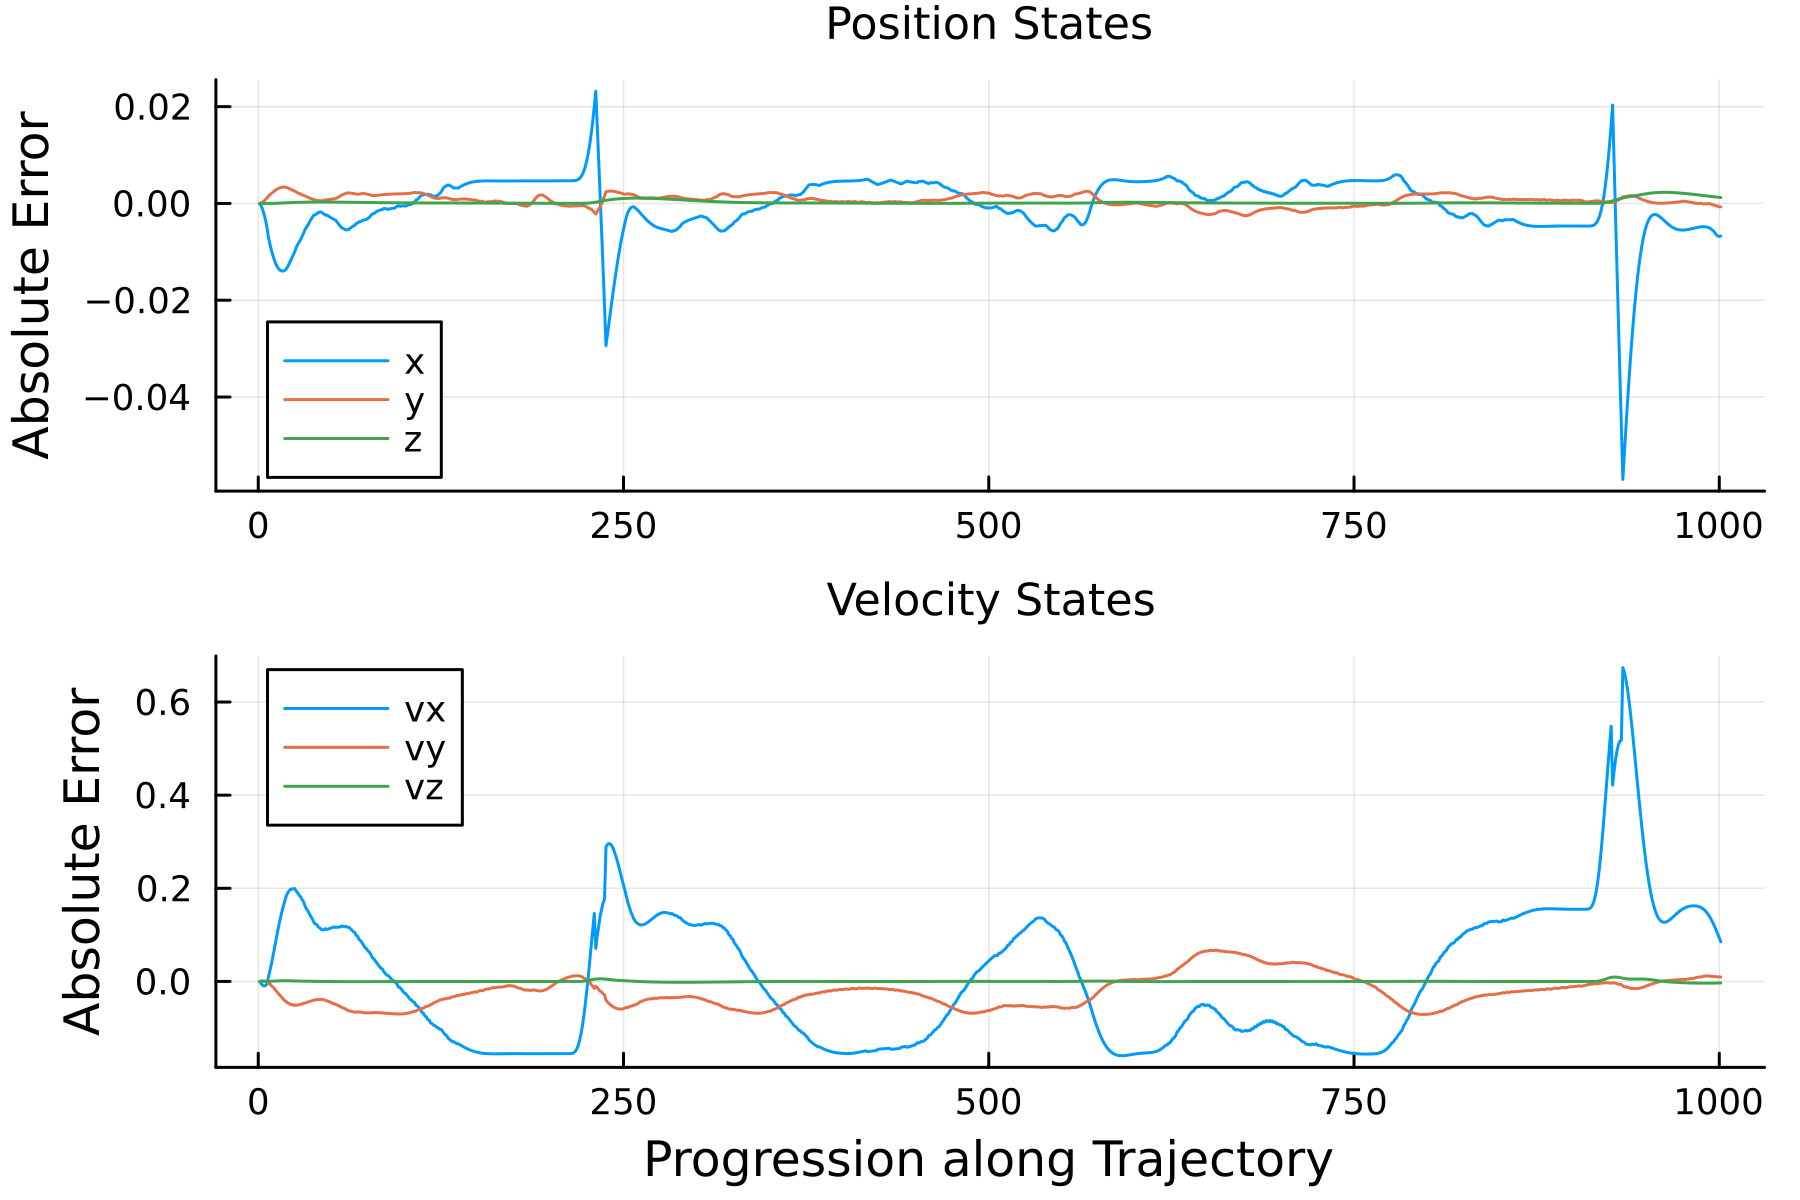

"/Users/ashleykline/CMU/24-774 Advanced Control Systems Integration/project/traj_gen_v2/figure_hi_error_MAGNET.png"

In [ ]:
# # visualization
# position_history= "figure_fig8FD_position_MAGNET.png"
# orientation_history= "figure_fig8FD_orientation_MAGNET.png"
# linear_velocity_history= "figure_fig8FD_linvelocity_MAGNET.png"
# ang_velocity_history= "figure_fig8FD_angvelocity_MAGNET.png"
# traj= "figure_fig8FD_trajfollowing_MAGNET.png"
# controls= "figure_fig8FD_controls_MAGNET.png"
# error_calc= "figure_fig8FD_error_MAGNET.png"
# # error_vel= "figure_fig8FD_error_velocity.png"

# position_history= "figure_circleFD_position_MAGNET.png"
# orientation_history= "figure_circleFD_orientation_MAGNET.png"
# linear_velocity_history= "figure_circleFD_linvelocity_MAGNET.png"
# ang_velocity_history= "figure_circleFD_angvelocity_MAGNET.png"
# traj= "figure_circleFD_trajfollowing_MAGNET.png"
# controls= "figure_circleFD_controls_MAGNET.png"
# error_calc= "figure_circleFD_error_MAGNET.png"
# # error_vel= "figure_circleFD_error_velocity.png"

# position_history= "figure_cloudFD_position_MAGNET.png"
# orientation_history= "figure_cloudFD_orientation_MAGENT.png"
# linear_velocity_history= "figure_cloudFD_linvelocity_MAGNET.png"
# ang_velocity_history= "figure_cloudFD_angvelocity_MAGNET.png"
# traj= "figure_cloudFD_trajfollowing_MAGNET.png"
# controls= "figure_cloudFD_controls_MAGNET.png"
# error_calc= "figure_cloudFD_error_MAGNET.png"
# # error_vel= "figure_cloudFD_error_velocity_MAGNET.png"

# position_history= "figure_humanFD_position_morepoints_MAGNET.png"
# orientation_history= "figure_humanFD_orientation_morepoints_MAGNET.png"
# linear_velocity_history= "figure_humanFD_linvelocity_morepoints_MAGNET.png"
# ang_velocity_history= "figure_humanFD_angvelocity_morepoints_MAGNET.png"
# traj= "figure_humanFD_trajfollowing_morepoints_MAGNET.png"
# controls= "figure_humanFD_controls_morepoints_MAGNET.png"
# error_calc= "figure_humanFD_error_morepoints_MAGNET.png"
# # error_vel= "figure_humanFD_error_velocity_MAGNET.png"

# state_history1= "figure_catFD_statehistoryMAGNET.png"
# linear_velocity= "figure_catFD_linvelocityMAGNET.png"
# traj= "figure_catFD_trajfollowingMAGNET.png"
# controls= "figure_catFD_controlsMAGNET.png"
# error_calc= "figure_catFD_errorMAGNET.png"
## error_vel= "figure_catFD_error_velocity.png"

position_history= "figure_hi_position_MAGNET.png"
orientation_history= "figure_hi_orientation_MAGNET.png"
linear_velocity_history= "figure_hi_linvelocity_MAGNET.png"
ang_velocity_history= "figure_hi_angvelocity_MAGNET.png"
traj= "figure_hi_trajfollowing_MAGNET.png"
controls= "figure_hi_controls_MAGNET.png"
error_calc= "figure_hi_error_MAGNET.png"
error_vel= "figure_humanFD_error_velocity.png" # showing how velocity affects the error


# visualize_quad_state(X_sim[1:NSIM-horizonLength])
visualize_quad_state(X_sim[1:NSIM], Xref[1:end], position_history, orientation_history,linear_velocity_history, ang_velocity_history)
# visualize_quad_xy(X_sim[1:NSIM-horizonLength], Xref[1:end])
visualize_quad_xy(X_sim[1:NSIM], traj, Xref[1:end])
visualize_controls(u_current[1:end-1], controls)
error_calculation(Xref, X_sim, error_calc)

In [ ]:
#animation

include(joinpath(@__DIR__, "visualization.jl")) # mesh cat visualizer
display(animate_Crazyflie(X_sim, model.dt, Xref))

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("vic1" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x76, 0x69, 0x63, 0x31, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x76, 0x69, 0x63, 0x31, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "trajectory" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p623" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x70, 0x36, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p838" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x70, 0x38, 0x33, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p874" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x70, 0x38, 0x37, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p913" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x70, 0x39, 0x31, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s610" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x73, 0x36, 0x31, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s550" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x73, 0x35, 0x35, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p499" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x70, 0x34, 0x39, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s196" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x74, 0x6f, 0x72, 0x79, 0x2f, 0x73, 0x31, 0x39, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8707, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8707

Notes
- dead zone in z velocity is 0.3

- onboard MPC needs to run at 40 hz
- onboard would track over a short horizon at like 20Hz
- ie shorten the horizon and track the optimal reference 
- add enough z velocity to get past dead zone
